In [143]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb" #HEADER_LEN,X_DIM,Y_DIM,X_left_boundry,X_right_boundry,Y_left_boundry,Y_right_boundry
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb" # frame rate, shutter delay, pixel_size, and interseted position 
%run "get_backbround_average_.ipynb" 
%run "frame_vs_temperature.ipynb" # get_powers funciton

In [144]:
folder = "/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023"

In [145]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files)
power_list = get_powers(all_files)

[4, 28, 2, 2, 18, 2, 12, 1, 8, 5, 41]


In [146]:
# v_list = ['103','13', '155', '190','234','30','352','45', '68']
v_list = ['103','13', '155', '190','20', '234','30','352','45', '68', '9']
Dict_1 = dict((k, fivemm_files[k][5:]) for k in v_list) # not included 0W files
back_intensity_list_1 = []
for key in fivemm_files:
    if key in v_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_1.append(back_intensity_list[index])
dRoverR_1 = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_1[i], gaus, gaus)
        con.append(val)
    dRoverR_1.append(con)

In [147]:
power_used = {}
for i in range(len(velocity_list)):
    [v] = velocity_list[i]
    power_used[v] = [int(j) for j in power_list[i][1:]]
    

### Plot all frames vs dR/R

In [ ]:
for i, (key, value) in enumerate(all_files.items()):
    power = [int(x) for x in power_list[i]][1:]
    files = all_files[key]
    
    for p in power:
        dR_list = []
        for file in tqdm(files):
            if "_{}W_".format(p) in str(file):
                print(str(file))
                dR = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
                dR_list.append(dR)
        
        x = [frame for frame in range(0,len(dR_list))] 
         
        plt.plot(x, dR_list, marker="o")
        plt.title("{}mm per sec".format(key))
        plt.xlabel("frame")
        plt.ylabel("dR/R")
        plt.ylim(0,0.4)
        
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_dRoverR_vs_frame/{}mmpersec.png".format(key), format="PNG")
    plt.close()

### Plot position vs temperature

In [ ]:
for i, (key, value) in enumerate(all_files.items()):
    power = [int(x) for x in power_list[i]][1:]
    files = all_files[key]
    
    for p in power:
        dR_list = []
        temp_list = []
        for file in tqdm(files):
            if "_{}W_".format(p) in str(file):
                print(str(file))
                dR = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
                dR_list.append(dR)
                temp_list.append(dR/0.00016+21)
                
        #convert the frame number to position 
        
        x = [frame for frame in range(0,len(dR_list))] 
        #position = [(frame-2.7)*int(key)/92.59 for frame in range(1,len(temp_list)+1)] why?
        position = [(frame/frame_rate-shutter_delay)*int(key) for frame in range(1,len(temp_list)+1)]
        
        plt.plot(position, temp_list, marker="o")

        #limit temperature to 1500C
        plt.ylim(0,1500)
        
        #limit position to 1-10mm
        plt.xlim(0,10)

        plt.xlabel("position (mm)")
        plt.ylabel("Temperature (Celsius)")
        plt.title("{}mm per sec".format(key))

    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_Temp_vs_position/{}mmpersec.png".format(key), format="PNG")
    plt.close()

### Plot all powers dR/R for each velocity

In [148]:
for i, v in enumerate(list(Si_melting_W.keys())):
    plt.plot(power_used[v], dRoverR_1[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.title("{}mm per sec".format(v))
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_dRoverR_vs_power/{}mm.png".format(v), format="PNG")
    plt.close()


### get kappa (use glod and Si melting power)

0.00019880482439054516

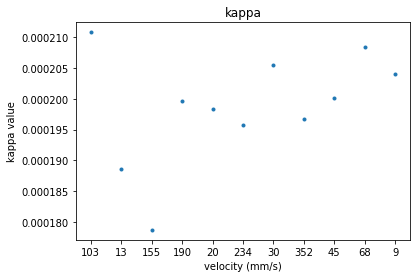

In [151]:
# gold and Si melt
import scipy.optimize
kappa_avg = []
for i, v in enumerate(list(Si_melting_W.keys())):
    popt, pcov = curve_fit(expo, power_used[v], dRoverR_1[i], p0 = [1, 0.0000000081, 1], maxfev = 10000)
    #a, b, c = popt
    plt.plot(power_used[v], dRoverR_1[i], '.')
    y_pred = [expo(j, *popt) for j in power_used[v]]
    plt.plot(power_used[v], y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.title("{}mm per sec".format(v))
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    
    
    fun = lambda k: (expo(Si_melting_W[v], *popt) - (1410-21)*k)**2 + (expo(gold_melting_W[v], *popt) - (1064-21)*k)**2
    res = scipy.optimize.minimize(fun, 0.00016)
    temp_pred = [expo(j, *popt)/res.x for j in power_used[v]]
    plt.plot(power_used[v], temp_pred)
    
    plt.plot(Si_melting_W[v], 1410, marker="o",color = 'r', label='Si')
    plt.plot(gold_melting_W[v], 1064, marker="o", color = 'g', label='gold')
    plt.legend(loc="upper left")
    plt.xlabel("power")
    plt.ylabel("temperature")
    plt.title("{}mm per sec".format(v))
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_gold_Si_fit/{}mm.png".format(v), format="PNG")
    plt.close()
    
#     f = expo(Si_melting_W[v], *popt)
#     gold_m = 1410
#     dT = gold_m - 21
#     kappa = f / dT
    kappa_avg.append(float(res.x))

    
Dict_kappa_avg = dict(zip(list(Si_melting_W.keys()),kappa_avg))

plt.plot(list(Si_melting_W.keys()), kappa_avg, '.')
plt.xlabel("velocity (mm/s)")
plt.ylabel("kappa value")
plt.title("kappa")
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_kappa_gold&Si.png", format="PNG")

con = 0
for i, v in enumerate(Dict_kappa_avg.keys()):
    con = con + Dict_kappa_avg[v]
kappa_avg = con / len(Dict_kappa_avg)
kappa_avg

In [152]:
peak_temp = []
for i, v in enumerate(list(Si_melting_W.keys())):
    tem = []
    for r in dRoverR_1[i]:
        t = get_peak_Temp(r, Dict_kappa_avg[v])
#         t = get_peak_Temp(r,avg_kappa)
#         t = get_peak_Temp(r,0.00016498400434141028)
#         t = get_peak_Temp(r, Dict_kappa_gold_avg[v])
#         t = get_peak_Temp(r, avg_kappa_2)
#         t = get_peak_Temp(r, Dict_kappa_avg[v])
        tem.append(t)
    peak_temp.append(tem)
    
Dict_peak_temp = dict(zip(list(Si_melting_W.keys()),peak_temp))

# plot temperature vs power

In [153]:
%matplotlib
for i,v in enumerate(Dict_peak_temp):
    plt.plot(power_used[v], Dict_peak_temp[v], label = "{}mm per sec".format(v))
    plt.title("Peak Temperature vs Power")
    plt.xlabel("power (W)")
    plt.ylabel("Temperature (Celsius)")
    plt.legend()
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_temp_vs_power.png", format="PNG")

Using matplotlib backend: MacOSX


# fit plane f(power, log10 velocity) = Tpeak 

In [157]:
v_fit_list = ['103','13', '155', '190','234','30','352','45', '68']



### The one I sent to them

In [158]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e, f, g, h):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(v_fit_list):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
[ 5.70876191e+02 -1.04083934e+02 -8.74318621e+02  9.94203745e+01
  1.61210309e+03  1.11499903e+00  2.25988118e-02  4.29208894e+00]
1091.3678766433372


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_4578/1971765713.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


### converter

In [159]:
parameters_T = np.array([ 5.70876191e+02 ,-1.04083934e+02, -8.74318621e+02 , 9.94203745e+01,
  1.61210309e+03,  1.11499903e+00 , 2.25988118e-02 , 4.29208894e+00])

def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    a, b, c, d, e, f, g, h= parameters_T
    eq1 = lambda x: (a+b*lnv+h*lnv**2)*x**(f+g*lnv) + (c+d*lnv)*x + e  - Tpeak
    sol = leastsq(eq1, 100)
    #return float(sol[0], sol[1]), float(sol[1])
    return float(sol[0])

In [161]:
get_power(88200/13, 1064)

31.02566321767916

# lateral temperature profile

In [41]:
dRoverR_line = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_laterial_fit_line(file, back_intensity_list[i], two_lorentz)
        con.append(val)
    dRoverR_line.append(con)
    

temp_line = []    
for i, v in enumerate(list(Dict_1.keys())):
    con_2 = []
    velo = dRoverR_line[i]
    for R in velo:
        temp = get_peak_Temp(R, Dict_kappa_avg[v])
        con_2.append(temp)
    temp_line.append(con_2)
    
parameters = []
for i, v in enumerate(list(Dict_1.keys())):
    con_3 = []
    velo = temp_line[i]
    for t in velo:
        # [height, x_0, sigma1, sigma2] = fit(two_lorentz, t)
        par = fit(two_lorentz, t)
        con_3.append(par)
    parameters.append(con_3)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# fit sigma1, sigma2 plane

In [101]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

beamwidth = 88200

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

# def function(data, a, b, c, d, e, f, g, h):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

def function(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g


points_1 = []
points_2 = []

for i, v in enumerate(list(Si_melting_W.keys())):
    T = Dict_peak_temp[v]
    P = [int(p) for p in power_used[v]]
    tau = [np.log(beamwidth / int(v))] * len(Dict_peak_temp[v])
    sigma1 = [abs(el[2]) for el in parameters[i]]
    sigma2 = [abs(el[3]) for el in parameters[i]]
    point1 = [list(x) for x in zip(*[P,tau,sigma1,T])]
    points_1.append(point1)
    point2 = [list(x) for x in zip(*[P,tau,sigma2,T])]
    points_2.append(point2)

    
x_data = []
y_data = []
t_data = []
z_data_1 = []
z_data_2 = []

for velo in points_1:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # tau
        z_data_1.append(item[2]) # sigma1
        t_data.append(item[3]) # Tpeak
        

for velo in points_2:
    for item in velo:
        z_data_2.append(item[2]) # sigma2
        
        
x_data, y_data, z_data_1, z_data_2, t_data = np.array(x_data), np.array(y_data), np.array(z_data_1), np.array(z_data_2), np.array(t_data)


mask = t_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data_1 = z_data_1[mask]
z_data_2 = z_data_2[mask]

mask_2 = z_data_1 < 1000
x_data = x_data[mask_2]
y_data = y_data[mask_2]
z_data_1 = z_data_1[mask_2]
z_data_2 = z_data_2[mask_2]


parameters_1, covariance_1 = curve_fit(function, [x_data, y_data], z_data_1,  maxfev=1000000)
parameters_2, covariance_2 = curve_fit(function, [x_data, y_data], z_data_2,  maxfev=1000000)

print(parameters_1)
print(parameters_2)

model_x_data = np.linspace(min(x_data), max(x_data), 100)
model_y_data = np.linspace(min(y_data), max(y_data), 100)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z1 = function(np.array([X, Y]), *parameters_1)
Z2 = function(np.array([X, Y]), *parameters_2)

z_predicted_1 = function([x_data, y_data], *parameters_1)
z_predicted_2 = function([x_data, y_data], *parameters_2)

differences_1 = np.subtract(z_data_1, z_predicted_1)
differences_2 = np.subtract(z_data_2, z_predicted_2)

squared_differences_1 = np.square(differences_1)
squared_differences_2 = np.square(differences_2)

mse_1 = squared_differences_1.mean()
mse_2 = squared_differences_2.mean()
print(mse_1)
print(mse_2)

Using matplotlib backend: MacOSX
[-2.01368882e-04  8.11514292e-01 -2.14748500e-04  5.51476175e-01
  3.29707265e-01  3.88422847e+00  2.02382709e+02]
[ 5.22927396e-04  8.02957177e-01 -3.56250837e-04  6.71256250e-01
 -4.41984168e+00 -8.53208461e+00  3.90706627e+02]
10932.668023224218
941.0774781941243


In [79]:
# len(temp_line[0])

# %matplotlib
# a,b,c,d = fit(two_lorentz, temp_line[8][5])
# plt.plot(temp_line[8][5])
# # plt.plot(np.linspace(0,149,150),temp_line[0][5] )
# plt.plot(np.linspace(0,149,150), two_lorentz(np.linspace(0,149,150),a,b,c,d))
# plt.xlabel("pixel")
# plt.ylabel("Temperature (Celsius)")
# print(a,b,c,d)

# import statistics 
# print(statistics.mean(z_data_1))
# print(statistics.mean(z_data_2))
# print(statistics.stdev(z_data_1))
# print(statistics.stdev(z_data_2))
# print(max(z_data_1))
# print(min(z_data_1))
# print(max(z_data_2))
# print(min(z_data_2))
# print(len(z_data_1))
# plt.plot(z_data_2)

8

In [102]:
f1 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes1 = Axes3D(f1)

axes1.plot_surface(X, Y, Z1, cmap=cm.hot, alpha=0.2)
axes1.scatter(x_data, y_data, z_data_1, s=500)

axes1.set_title('Scatter Plot')
axes1.set_xlabel('power - W', fontsize=30, labelpad=40)
axes1.set_ylabel('tau',fontsize=30, labelpad=40)
axes1.set_zlabel('sigma1', fontsize=30, labelpad=40)

axes1.tick_params(axis='both', which='major', labelsize=30)
 
plt.show()
print(mse_1)

10932.668023224218


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_5167/2512510063.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes1 = Axes3D(f1)


In [104]:
f2 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes2 = Axes3D(f2)

axes2.plot_surface(X, Y, Z2, cmap=cm.hot, alpha=0.2)
axes2.scatter(x_data, y_data, z_data_2, s=500)

axes2.set_title('Scatter Plot')
axes2.set_xlabel('power - W', fontsize=30, labelpad=40)
axes2.set_ylabel('tau',fontsize=30, labelpad=40)
axes2.set_zlabel('sigma2', fontsize=30, labelpad=40)

axes2.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse_2)

941.0774781941243


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_5167/3592995763.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes2 = Axes3D(f2)


2023-02-27 00:35:15.686 Python[5167:165270] _TIPropertyValueIsValid called with 4 on nil context!
2023-02-27 00:35:15.686 Python[5167:165270] imkxpc_getApplicationProperty:reply: called with incorrect property value 4, bailing.
2023-02-27 00:35:15.686 Python[5167:165270] Text input context does not respond to _valueForTIProperty:
2023-02-27 00:35:15.689 Python[5167:165270] _TIPropertyValueIsValid called with 4 on nil context!
2023-02-27 00:35:15.689 Python[5167:165270] imkxpc_getApplicationProperty:reply: called with incorrect property value 4, bailing.
2023-02-27 00:35:15.689 Python[5167:165270] Text input context does not respond to _valueForTIProperty:
2023-02-27 00:35:21.383 Python[5167:165270] _TIPropertyValueIsValid called with 4 on nil context!
2023-02-27 00:35:21.383 Python[5167:165270] imkxpc_getApplicationProperty:reply: called with incorrect property value 4, bailing.
2023-02-27 00:35:21.383 Python[5167:165270] Text input context does not respond to _valueForTIProperty:
2023

# converter

In [ ]:
parameters_sigma1 = np.array([ -2.01368882e-04 , 8.11514292e-01, -2.14748500e-04,  5.51476175e-01,
  3.29707265e-01,  3.88422847e+00 , 2.02382709e+02])

def get_sigma1(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    a, b, c, d, e, f, g, h= parameters_T
    eq1 = lambda x: (a+b*lnv+h*lnv**2)*x**(f+g*lnv) + (c+d*lnv)*x + e  - Tpeak
    sol = leastsq(eq1, 100)
    #return float(sol[0], sol[1]), float(sol[1])
    return float(sol[0])